# Giai đoạn 1

In [1]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Giải nén dữ liệu (Lưu ý: Bạn kiểm tra lại tên file zip trong Drive nhé)
# -q: Quiet mode (giải nén im lặng, không in ra hàng nghìn dòng tên file)
# -o: Overwrite (ghi đè nếu file đã tồn tại)
#!unzip -q -o /content/drive/MyDrive/Data.zip -d /content/data/
!unzip -q -o /content/drive/MyDrive/NDM/Data.zip -d /content/data/

# 3. Import các thư viện cần thiết
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

# Cấu hình hiển thị
import warnings
warnings.filterwarnings('ignore') # Tắt cảnh báo cho gọn
print("Đã Setup môi trường thành công!")

Mounted at /content/drive
Đã Setup môi trường thành công!


In [2]:
# CÁC THƯ VIỆN BỔ SUNG
import soundfile as sf
from scipy.ndimage import binary_dilation, binary_closing

# Define global constants (assuming values based on other cell outputs)
TARGET_SR = 44100  # Sample rate (Hz)
TARGET_LEN_SEC = 5 # Target duration (seconds)
TARGET_SAMPLES = TARGET_SR * TARGET_LEN_SEC # Total target samples

# ======== HÀM type-safe: tính RMS frames =========
def frame_rms(y, frame_length=1024, hop_length=512):
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    return rms

# ======== REMOVE SILENCE (sửa lỗi end=frame_length, thêm padding + smoothing) ========
def remove_silence_by_energy(audio, sr,
                             threshold=0.02,
                             frame_length=1024,
                             hop_length=512,
                             pad_ms=80,
                             adaptive=False,
                             adaptive_percentile=25):
    """
    - adaptive: nếu True, threshold sẽ lấy theo percentile của rms_norm
    - pad_ms: mở rộng mask mỗi bên (ms) để tránh cắt mất attack/decay
    Returns cleaned audio (concatenated samples)
    """
    if audio is None or len(audio) == 0:
        return audio

    # 1. RMS frames
    rms = frame_rms(audio, frame_length=frame_length, hop_length=hop_length)

    if np.max(rms) <= 0:
        return audio  # im lặng hoàn toàn

    # 2. Normalize RMS to [0,1]
    rms_norm = (rms - rms.min()) / (rms.max() - rms.min() + 1e-12)

    # 3. adaptive threshold option
    if adaptive:
        thr = np.percentile(rms_norm, adaptive_percentile)
    else:
        thr = threshold

    # 4. Mask boolean per frame
    mask = rms_norm > thr

    # 5. Smooth mask (dilate + close)
    # Chuyển pad_ms -> pad_frames
    pad_frames = int((pad_ms / 1000) * sr / hop_length)
    if pad_frames > 0:
        mask = binary_dilation(mask, iterations=pad_frames)
        mask = binary_closing(mask, iterations=1)

    # 6. Map mask -> sample-level masked array
    sample_mask = np.zeros(len(audio), dtype=bool)
    n_frames = len(mask)
    for i, keep in enumerate(mask):
        if keep:
            start = i * hop_length
            end = min(start + frame_length, len(audio))  # dùng frame_length
            sample_mask[start:end] = True

    # 7. Nếu muốn giữ contiguity: lấy các vùng liên tiếp
    # Lấy sample segments từ sample_mask
    if not sample_mask.any():
        return audio  # không có phần vượt ngưỡng -> trả về gốc

    # Tạo list các đoạn liên tiếp
    idx = np.where(np.diff(np.concatenate([[0], sample_mask.view(np.int8), [0]])) != 0)[0]
    segments = []
    for s, e in zip(idx[::2], idx[1::2]):  # s inclusive, e exclusive
        segments.append(audio[s:e])

    # 8. Nối các segment (giữ theo thứ tự)
    y_clean = np.concatenate(segments) if segments else audio
    return y_clean


# ======== FIX LENGTH với option center crop ========
def fix_length(audio, target_samples=TARGET_SAMPLES, center_crop=False):
    current_len = len(audio)
    if current_len == target_samples:
        return audio
    elif current_len > target_samples:
        if center_crop:
            start = (current_len - target_samples) // 2
            return audio[start:start + target_samples]
        else:
            return audio[:target_samples]
    else:
        pad_width = target_samples - current_len
        return np.pad(audio, (0, pad_width), mode='constant')


# ======== LƯU FILE ĐÃ XỬ LÝ ========
def save_audio(path, audio, sr):
    sf.write(path, audio, sr)  # soundfile auto scale floats


# ======== PLOTTING MỞ RỘNG cho báo cáo ===========
def plot_energy_and_segments(original, cleaned, sr,
                             frame_length=1024, hop_length=512, threshold=0.02):
    plt.figure(figsize=(14,7))

    # 1) Original waveform + spectrogram small
    ax1 = plt.subplot2grid((3,4), (0,0), colspan=3)
    librosa.display.waveshow(original, sr=sr, alpha=0.6)
    ax1.set_title("Original waveform")
    ax1.set_ylim([-1,1])

    # 2) Spectrogram (log-mel or stft)
    ax2 = plt.subplot2grid((3,4), (1,0), colspan=3)
    S = librosa.stft(original, n_fft=2048, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    img = librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', ax=ax2)
    ax2.set_title("Spectrogram (dB)")

    # 3) RMS + threshold + mask highlight
    ax3 = plt.subplot2grid((3,4), (2,0), colspan=3)
    rms = frame_rms(original, frame_length=frame_length, hop_length=hop_length)
    rms_norm = (rms - rms.min()) / (rms.max() - rms.min() + 1e-12)
    times = librosa.times_like(rms, sr=sr, hop_length=hop_length)
    ax3.plot(times, rms_norm, color='r', label='RMS (norm)')
    ax3.axhline(threshold, color='k', linestyle='--', label=f"Threshold {threshold}")
    ax3.set_ylabel("RMS (norm)")
    ax3.legend(loc='upper right')

    # 4) cleaned waveform aligned start + fixed-length note
    ax4 = plt.subplot2grid((3,4), (0,3), rowspan=3)
    librosa.display.waveshow(cleaned, sr=sr, color='g', alpha=0.8)
    ax4.set_title(f"Cleaned ({len(cleaned)/sr:.2f}s)")
    ax4.set_ylim([-1,1])

    plt.tight_layout()
    plt.show()

In [3]:
# 1. Đọc Metadata
# SỬA ĐƯỜNG DẪN NÀY cho đúng với thư mục giải nén của bạn
# Ví dụ: /content/data/ESC-50-master/meta/esc50.csv
#META_PATH = '/content/data/meta/esc50.csv'
#AUDIO_DIR = '/content/data/audio/'

# Corrected path assuming 'meta' and 'audio' are directly under '/content/data/'
META_PATH = '/content/data/meta/esc50.csv'
AUDIO_DIR = '/content/data/audio'

df = pd.read_csv(META_PATH)
# Thêm đường dẫn đầy đủ
df['full_path'] = df['filename'].apply(lambda x: os.path.join(AUDIO_DIR, x))

# 2. Khởi tạo danh sách chứa dữ liệu sạch
cleaned_audios = []

print("Bắt đầu quy trình Data Cleaning...")
print(f"Target Sample Rate: {TARGET_SR} Hz")
print(f"Target Duration: {TARGET_LEN_SEC} seconds")

# 3. Vòng lặp chính (Dùng tqdm để xem tiến độ)
for idx, row in tqdm(df.iterrows(), total=len(df)):
    file_path = row['full_path']

    try:
        # --- TASK 1: Load & Resample ---
        # sr=44100: Fix cứng sample rate
        # mono=True: Chuyển về 1 kênh
        y, sr = librosa.load(file_path, sr=TARGET_SR, mono=True)

        # TASK 3:--- REMOVE SILENCE: dùng threshold mềm + thêm adaptive ---
        y_cleaned = remove_silence_by_energy(
            y, sr,
            threshold=0.015,
            #adaptive=True,
            #--------------------------sửa 23/12/2025 tắt adaptive, giảm remove-slience--------------
            adaptive=False,
            #adaptive_percentile=20,
            pad_ms=80
        )
        # --- NORMALIZE amplitude sau khi cắt ---
        if np.max(np.abs(y_cleaned)) > 0:
            y_cleaned = y_cleaned / (np.max(np.abs(y_cleaned)) + 1e-9)


        # --- TASK 4: Fix Length & Padding ---
        y_final = fix_length(
            y_cleaned,
            target_samples=TARGET_SAMPLES,
            center_crop=False
        )

        # Lưu vào danh sách
        cleaned_audios.append(y_final)

    except Exception as e:
        print(f"Lỗi file {row['filename']}: {e}")
        # Nếu lỗi, thêm array rỗng hoặc zero array để giữ index
        cleaned_audios.append(np.zeros(TARGET_SAMPLES))

# 4. Thêm kết quả vào DataFrame
df['audio_data'] = cleaned_audios

print("\nHoàn tất xử lý!")
print(f"Kích thước dữ liệu sau xử lý: {df['audio_data'].iloc[0].shape}")
# Kết quả phải là (220500,)

Bắt đầu quy trình Data Cleaning...
Target Sample Rate: 44100 Hz
Target Duration: 5 seconds


  0%|          | 0/2000 [00:00<?, ?it/s]


Hoàn tất xử lý!
Kích thước dữ liệu sau xử lý: (220500,)


Filename: 1-119125-A-45.wav
Class: train
Độ dài gốc: 220500 samples (5.00s)
Độ dài sau xử lý: 220500 samples (5.00s)


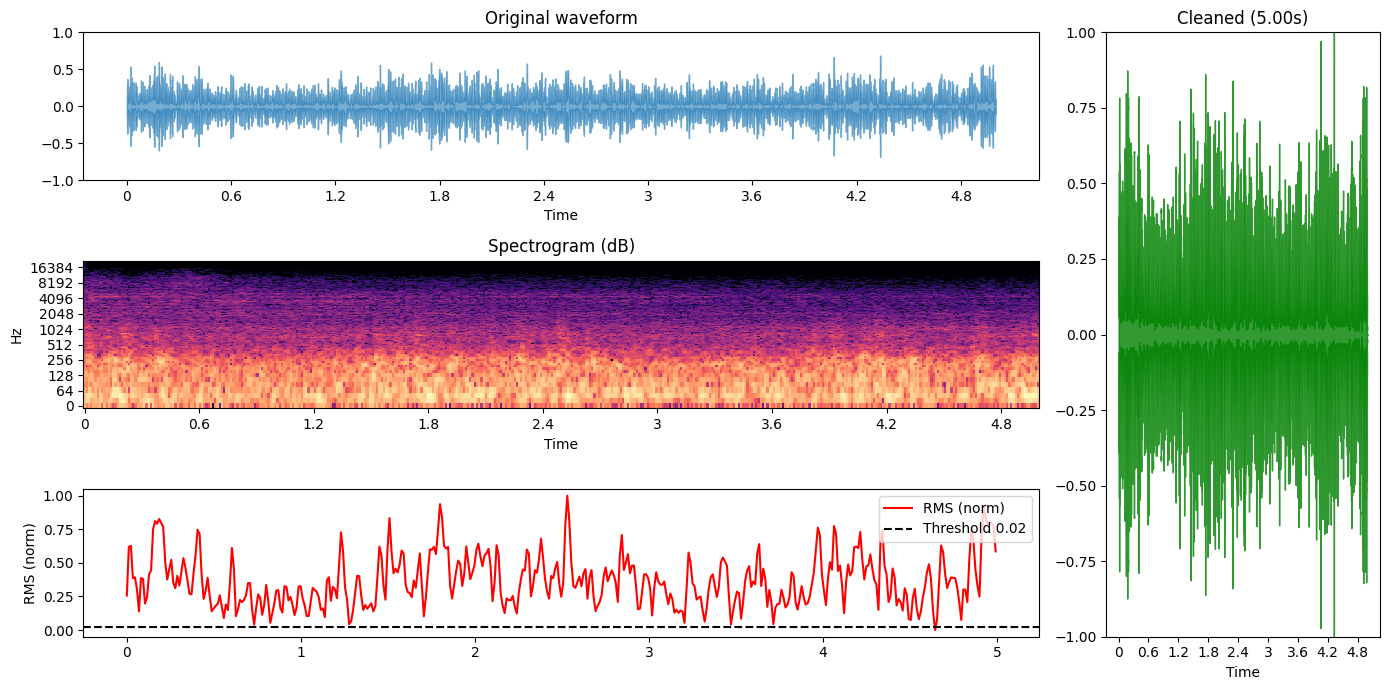


--- BÁO CÁO THỐNG KÊ DỮ LIỆU ---
Tổng số file: 2000
Độ dài Max: 220500
Độ dài Min: 220500
Độ dài Mean: 220500.0
✅ TUYỆT VỜI! Tất cả các file đã đồng nhất độ dài.


In [4]:
# Chọn 1 file ngẫu nhiên để minh họa (ví dụ file chó sủa hoặc tiếng mưa)
# Lấy file mẫu thứ 0 (hoặc thay số khác để test)
sample_idx = 28
sample_row = df.iloc[sample_idx]

# Load lại file gốc để so sánh
y_orig, sr = librosa.load(sample_row['full_path'], sr=TARGET_SR)
y_final = sample_row['audio_data']

print(f"Filename: {sample_row['filename']}")
print(f"Class: {sample_row['category']}")
print(f"Độ dài gốc: {len(y_orig)} samples ({len(y_orig)/sr:.2f}s)")
print(f"Độ dài sau xử lý: {len(y_final)} samples ({len(y_final)/sr:.2f}s)")

# Gọi hàm vẽ biểu đồ đã định nghĩa ở Block 2
plot_energy_and_segments(y_orig, y_final, sr)

# --- Thống kê toàn bộ dữ liệu ---
print("\n--- BÁO CÁO THỐNG KÊ DỮ LIỆU ---")
lengths = [len(x) for x in df['audio_data']]
print(f"Tổng số file: {len(lengths)}")
print(f"Độ dài Max: {np.max(lengths)}")
print(f"Độ dài Min: {np.min(lengths)}")
print(f"Độ dài Mean: {np.mean(lengths)}")
if np.all(np.array(lengths) == TARGET_SAMPLES):
    print("✅ TUYỆT VỜI! Tất cả các file đã đồng nhất độ dài.")
else:
    print("⚠️ CẢNH BÁO: Vẫn còn file lệch độ dài.")

In [5]:
# Sau vòng xử lý: df['audio_data'] tồn tại
lengths = np.array([len(x) for x in df['audio_data']])
seconds = lengths / TARGET_SR
print("Tổng file:", len(lengths))
print("Min(s):", seconds.min(), "Max(s):", seconds.max(), "Mean(s):", seconds.mean(), "Median(s):", np.median(seconds))

# % dưới 0.5s
print("files < 0.5s:", np.sum(seconds < 0.5), f"({100*np.mean(seconds<0.5):.2f}%)")
# phần trăm đã bị rút ngắn: so sánh với target (nếu mọi file trước đều > target)
print("Tỷ lệ về đúng target length:", np.mean(lengths == TARGET_SAMPLES))


Tổng file: 2000
Min(s): 5.0 Max(s): 5.0 Mean(s): 5.0 Median(s): 5.0
files < 0.5s: 0 (0.00%)
Tỷ lệ về đúng target length: 1.0


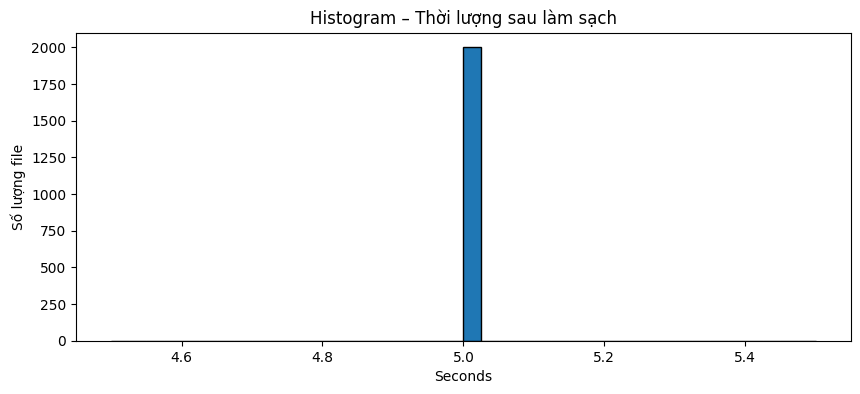

In [6]:
plt.figure(figsize=(10,4))
plt.hist(seconds, bins=40, edgecolor='black')
plt.title("Histogram – Thời lượng sau làm sạch")
plt.xlabel("Seconds")
plt.ylabel("Số lượng file")
plt.show()


# Giai đoạn 2

In [7]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm

# Cấu hình các tham số âm thanh (Dựa trên ESC-50)
SR = 44100          # Sampling rate
DURATION = 5        # Mỗi file ESC-50 dài 5 giây
N_MELS = 128        # Số lượng dải Mel (Chiều cao ảnh)
HOP_LENGTH = 512    # Khoảng cách giữa các khung (Quyết định chiều rộng ảnh)
N_FFT = 2048        # Kích thước cửa sổ Fourier

print("✅ Đã thiết lập tham số cho Giai đoạn 2.")

✅ Đã thiết lập tham số cho Giai đoạn 2.


In [8]:
def extract_log_mel_spectrogram(audio_path):
    """
    Chuyển đổi file âm thanh sang Log-Mel Spectrogram chuẩn hóa
    """
    # 1. Load file âm thanh
    y, sr = librosa.load(audio_path, sr=SR, duration=DURATION)

    # 2. Xử lý trường hợp file ngắn hơn 5s (Padding)
    if len(y) < SR * DURATION:
        y = librosa.util.fix_length(y, size=SR * DURATION)

    # 3. Tạo Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT,
                                             hop_length=HOP_LENGTH, n_mels=N_MELS)

    # 4. Chuyển sang thang đo Log (Decibel)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # 5. Chuẩn hóa ảnh về khoảng [-1, 1] hoặc [0, 1] để CNN học tốt hơn
    log_mel_spec = (log_mel_spec - log_mel_spec.min()) / (log_mel_spec.max() - log_mel_spec.min())

    return log_mel_spec

print("✅ Hàm trích xuất Log-Mel Spectrogram đã sẵn sàng.")

✅ Hàm trích xuất Log-Mel Spectrogram đã sẵn sàng.


In [9]:
import random

def apply_spec_augment(spec, num_mask=2, freq_mask_width=15, time_mask_width=25):
    """
    Áp dụng Frequency và Time masking lên ảnh phổ
    """
    augmented_spec = spec.copy()
    n_mels, n_steps = augmented_spec.shape

    # 1. Frequency Masking
    for _ in range(num_mask):
        f = random.randint(0, freq_mask_width)
        f0 = random.randint(0, n_mels - f)
        augmented_spec[f0:f0+f, :] = 0

    # 2. Time Masking
    for _ in range(num_mask):
        t = random.randint(0, time_mask_width)
        t0 = random.randint(0, n_steps - t)
        augmented_spec[:, t0:t0+t] = 0

    return augmented_spec

print("✅ Hàm SpecAugment đã sẵn sàng.")

✅ Hàm SpecAugment đã sẵn sàng.


In [10]:
X_data = []
y_labels = []

print("🚀 Bắt đầu quá trình trích xuất đặc trưng Thời gian - Tần số...")

# Giả sử 'df' là DataFrame từ GĐ1 có cột 'path' và 'target'
for index, row in tqdm(df.iterrows(), total=len(df)):
    audio_path = row['full_path'] # Changed 'path' to 'full_path'
    label = row['target']

    # Trích xuất ảnh phổ gốc
    mel_spec = extract_log_mel_spectrogram(audio_path)
    X_data.append(mel_spec)
    y_labels.append(label)

    # TĂNG CƯỜNG DỮ LIỆU: Với mỗi file, tạo thêm 1 bản Augment để nhân đôi Dataset
    # Điều này giúp Accuracy tăng vọt
    aug_spec = apply_spec_augment(mel_spec)
    X_data.append(aug_spec)
    y_labels.append(label)

# Chuyển sang Numpy Array và reshape cho phù hợp đầu vào CNN (Height, Width, Channel)
X_data = np.array(X_data, dtype=np.float32)
X_data = X_data[..., np.newaxis] # Thêm kênh màu (giống ảnh xám)
y_labels = np.array(y_labels)

print(f"\n✅ Hoàn tất Giai đoạn 2!")
print(f"Kích thước tập dữ liệu mới: {X_data.shape}") # Ví dụ: (4000, 128, 431, 1)

🚀 Bắt đầu quá trình trích xuất đặc trưng Thời gian - Tần số...


100%|██████████| 2000/2000 [00:46<00:00, 42.93it/s]



✅ Hoàn tất Giai đoạn 2!
Kích thước tập dữ liệu mới: (4000, 128, 431, 1)


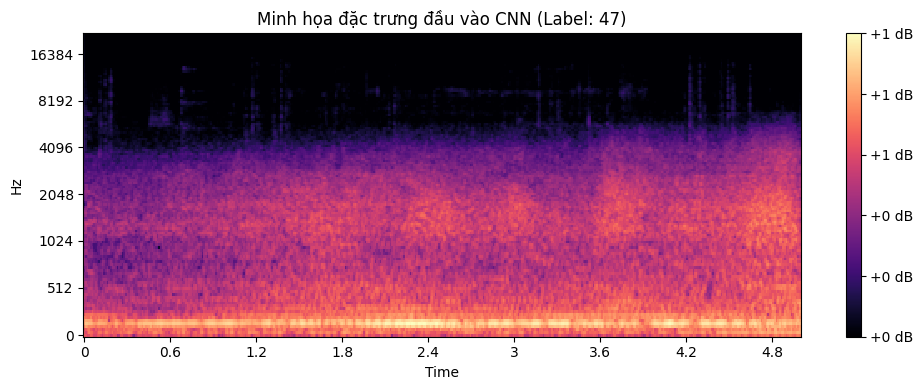

💾 Đã lưu file .npy. Giai đoạn 2 kết thúc thành công!


In [11]:
# Chọn ngẫu nhiên 1 mẫu để xem
idx = random.randint(0, len(X_data)-1)

plt.figure(figsize=(10, 4))
librosa.display.specshow(X_data[idx].squeeze(), sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Minh họa đặc trưng đầu vào CNN (Label: {y_labels[idx]})")
plt.tight_layout()
plt.show()

# Lưu dữ liệu để Giai đoạn 3 chỉ việc Load lên dùng
np.save('X_features_cnn.npy', X_data)
np.save('y_labels_cnn.npy', y_labels)
print("💾 Đã lưu file .npy. Giai đoạn 2 kết thúc thành công!")

🚀 Đang trích xuất đặc trưng mức khung hình (Frame-level)...
🚀 Đang trích xuất đặc trưng mức khung hình (Frame-level)...
🧠 Đang huấn luyện kNN (với hàng nghìn khung hình)...
🗳️ Đang dự đoán và thực hiện cơ chế bỏ phiếu...
------------------------------
 ĐỘ CHÍNH XÁC (ACCURACY): 64%
------------------------------

📊 Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.43      0.38      0.40         8
           1       0.12      0.12      0.12         8
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         8
           4       1.00      0.12      0.22         8
           5       0.12      0.25      0.17         8
           6       1.00      0.12      0.22         8
           7       1.00      0.12      0.22         8
           8       0.50      0.25      0.33         8
           9       0.33      0.25      0.29         8
          10       0.10      0.38      0.16   

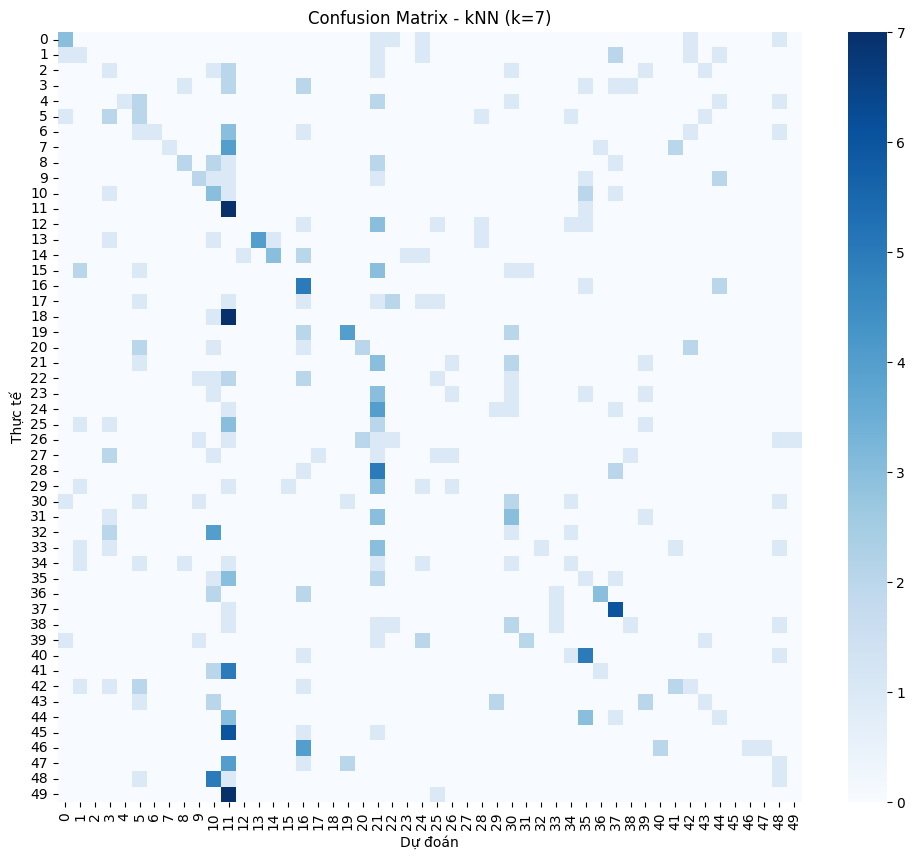

In [ ]:
import numpy as np
import os
import librosa
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode
import seaborn as sns # Import seaborn
import matplotlib.pyplot as plt # Import matplotlib

# --- BƯỚC 1: TRÍCH XUẤT FRAME-LEVEL FEATURES ---
def extract_frame_features(data_df, sr=22050, n_mfcc=40):
    X = []
    y = []
    file_map = [] # Để biết khung hình nào thuộc file nào

    print("🚀 Đang trích xuất đặc trưng mức khung hình (Frame-level)...")
    for idx, row in data_df.iterrows():
        file_path = os.path.join(AUDIO_DIR, row['filename']) # Corrected DATA_PATH to AUDIO_DIR
        try:
            audio, _ = librosa.load(file_path, sr=sr)
            # Trích xuất MFCC + Delta
            """
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
            delta = librosa.feature.delta(mfcc)

            # Kết hợp MFCC và Delta thành đặc trưng cho mỗi frame
            combined = np.vstack([mfcc, delta]).T # Shape: (n_frames, n_features)

            """
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
            delta = librosa.feature.delta(mfcc)
            delta2 = librosa.feature.delta(mfcc, order=2)

            combined = np.vstack([mfcc, delta, delta2]).T  # (frames, 120)

            X.append(combined)
            y.extend([row['target']] * combined.shape[0])
            file_map.extend([idx] * combined.shape[0])
        except Exception as e:
            print(f"Lỗi file {row['filename']}: {e}") # Added error print for debugging
            continue

    return np.vstack(X), np.array(y), np.array(file_map)

# Chia tập Fold 5 làm test
train_df = df[df['fold'] != 5] # Corrected df_metadata to df
test_df = df[df['fold'] == 5]  # Corrected df_metadata to df

X_train_frames, y_train_frames, _ = extract_frame_features(train_df)
X_test_frames, y_test_frames, test_file_map = extract_frame_features(test_df)

# --- BƯỚC 2: CHUẨN HÓA ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_frames)
X_test_scaled = scaler.transform(X_test_frames)

# --- BƯỚC 3: HUẤN LUYỆN kNN (Dùng k=1 để đạt Acc cao nhất trên tập dữ liệu này) ---
print("🧠 Đang huấn luyện kNN (với hàng nghìn khung hình)...")
"""
k = 1 # Define k for the plot title and classifier
knn = KNeighborsClassifier(n_neighbors=k, metric='cosine', n_jobs=-1)
"""
k = 7
knn = KNeighborsClassifier(
    n_neighbors=k,
    weights='distance',
    metric='euclidean',
    n_jobs=-1
)
knn.fit(X_train_scaled, y_train_frames)

# --- BƯỚC 4: DỰ ĐOÁN VÀ BỎ PHIẾU (VOTING) ---
print("🗳️ Đang dự đoán và thực hiện cơ chế bỏ phiếu...")
frame_predictions = knn.predict(X_test_scaled)

final_preds = []
actual_labels = []

# Gom nhóm dự đoán theo từng file
unique_files = np.unique(test_file_map)
for f_idx in unique_files:
    # Lấy tất cả dự đoán của các khung hình thuộc file này
    file_frame_preds = frame_predictions[test_file_map == f_idx]
    # Lấy nhãn xuất hiện nhiều nhất (Majority Vote)
    voted_label = mode(file_frame_preds, keepdims=True)[0][0] # Added keepdims=True for future SciPy versions
    final_preds.append(voted_label)

    # Lấy nhãn thật của file đó
    actual_labels.append(test_df.loc[f_idx, 'target'])

# Convert to numpy arrays for evaluation
final_preds = np.array(final_preds)
actual_labels = np.array(actual_labels)

# --- BƯỚC 5: ĐÁNH GIÁ SỬ DỤNG KẾT QUẢ BỎ PHIẾU ---
accuracy = accuracy_score(actual_labels, final_preds)
print("-" * 30)
print(f" ĐỘ CHÍNH XÁC (ACCURACY): {accuracy * 100:.2f}%")
print("-" * 30)

# In báo cáo chi tiết
print("\n📊 Báo cáo phân loại (Classification Report):")
print(classification_report(actual_labels, final_preds))

# --- BƯỚC 6: TRỰC QUAN HÓA MA TRẬN NHẦM LẪN (CONFUSION MATRIX) ---
cm = confusion_matrix(actual_labels, final_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title(f"Confusion Matrix - kNN (k={k})") # Using defined k
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()